# **Задание 1.** Сверточные нейронные сети

## Импорт библиотек и модулей

Импортируем необходимые библиотеки:

In [1]:
%%capture
!pip install torchmetrics lightning

In [79]:
import os
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torchmetrics.classification as metrics

from torchvision.transforms import v2 as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, RichProgressBar
from lightning.pytorch.loggers import CSVLogger
import sklearn as sl

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

При работе в Google Colab я также монтирую образ диска, чтобы загрузить датасет:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Зададим значение `seed` и зафиксируем его:

In [4]:
seed_value = 42

random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Сборка датасета

Соберем датасет. Сейчас я сохранил его в виде двух директорий, `generated` и `real`, соответствующих сгенерированным и реальным изображениям соответственно.

Объединим его в один список из кортежей вида `(img_path, label)`:

In [5]:
dataset_path = "./drive/MyDrive/dataset"
classes = ["generated", "real"]
gen_path = os.path.join(dataset_path, classes[0])  # generated <-> 0
real_path = os.path.join(dataset_path, classes[1])  # real <-> 1


def collect_imgs(class_path):
    imgs = [os.path.join(class_path, i) for i in os.listdir(class_path)]
    label = classes.index(str(class_path).split('/')[-1])
    return [(img, label) for img in imgs]


all_imgs = list()
all_imgs.extend(collect_imgs(gen_path))
all_imgs.extend(collect_imgs(real_path))

Разделим данные на тренировочную и валидационную выборки:

In [6]:
random.shuffle(all_imgs)  # for random sampling
imgs, labels = zip(*all_imgs)

train_imgs, val_imgs, train_labels, val_labels = sl.model_selection.train_test_split(
    imgs,
    labels,
    test_size=0.2,  # val includes 195 images of 975 (20%)
    stratify=labels,  # for balancing
    random_state=seed_value
)

train_data = [(img, label) for img, label in zip(train_imgs, train_labels)]
val_data = [(img, label) for img, label in zip(val_imgs, val_labels)]

Сформируем Dataset и DataModule, зададим аугментации и препроцессинг:

In [7]:
class GenRealImagesDataset(Dataset):
    def __init__(
            self,
            data: list[tuple],
            transform: T.Compose = None
    ):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)["image"]

        return img, torch.tensor(label, dtype=torch.long)

Здесь стоит описать аугментации, которые будут (и не будут) применяться в препроцессинге картинок.

Для тренировочной выборки:
* `RandomHorizontalFlip`/`RandomVerticalFlip` - флипы помогают разнообразить данные;
* `RandomRotation` - небольшие повороты, нужны для разнообразия;
* `ColorJitter` - умеренные цветовые изменения (например, насыщенность, контраст) могут усилить влияние отличительной черты генеративных моделей делать сильно контрастные и яркие изображения;
* `GaussianNoise` - гауссов шум акцентирует внимание на деталях и переходах (сгенерированные изображения, например, часто слишком "гладкие");
* Ресайз и нормализация до формата ImageNet ("стандарт" в компьютерном зрении).

Для валидационной выборки будет применяться только ресайз и нормализация.

**Не стоит** применять аугментации, сильно искажающие геометрию картинки, ее цвета и формы объектов - это может помешать модели корректно извлекать признаки.

In [8]:
class GenRealImagesModule(L.LightningDataModule):
    def __init__(
            self,
            train_data: list[tuple],
            val_data: list[tuple],
            batch_size: int = 16,
            n_workers: int = 2
    ):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size
        self.n_workers = n_workers

    @staticmethod
    def transform_train():
        t = A.Compose([
            A.Resize(256, 256),  # standard shape for ImageNet
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(10),
            A.ColorJitter(
                brightness=0.1,
                contrast=0.1,
                saturation=0.1,
                hue=0.1,
                p=0.75
            ),
            A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)
            ),
            ToTensorV2()
        ])

        return t

    @staticmethod
    def transform_val():
        t = A.Compose([
            A.Resize(256, 256),
            A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)
            ),
            ToTensorV2()
        ])

        return t

    def setup(self, stage=None):
        self.train_dataset = GenRealImagesDataset(self.train_data, transform=self.transform_train())
        self.val_dataset = GenRealImagesDataset(self.val_data, transform=self.transform_val())

    def train_dataloader(self):
        dl = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.n_workers,
            pin_memory=True if torch.cuda.is_available() else False
        )
        return dl

    def val_dataloader(self):
        dl = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.n_workers,
            pin_memory=True if torch.cuda.is_available() else False
        )
        return dl

In [9]:
datamodule = GenRealImagesModule(
    train_data=train_data,
    val_data=val_data
)
datamodule.setup()

Проверим размерность:

In [10]:
next(iter(datamodule.train_dataloader()))[0].shape

torch.Size([16, 3, 256, 256])

## Определение моделей

Определим классы для следующих моделей:

* кастомная блочная сверточная сеть на PyTorch;
* полностью обучаемый ResNet-50 (например, с нуля);
* ResNet-50 для использования **transfer learning** (freezed backbone).

In [11]:
# Custom CNN with Depthwise and Pointwise convs
class ConvolutionBlock(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int = 3,
            stride: int = 1,
            padding: int = 1,
            dropout_p: float = 0.0
    ):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    groups=in_channels,
                    bias=False
                ),
                nn.BatchNorm2d(in_channels),
                nn.LeakyReLU(),

                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=1,
                    padding=0,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(),
            ),
            nn.Dropout2d(p=dropout_p)
        )

    def forward(self, x):
        return self.layer(x)


class CustomCNN(L.LightningModule):
    def __init__(
            self,
            n_classes: int = 2,  # generated and real
            lr: float = 1e-3,
            weight_decay: float = 1e-4,
            eta_min: float = 1e-6
    ):
        super().__init__()
        self.save_hyperparameters()

        self.n_classes = n_classes

        self.backbone = nn.Sequential(
            ConvolutionBlock(
                in_channels=3,  # R, G, B
                out_channels=32,
                stride=2
            ),

            ConvolutionBlock(
                in_channels=32,
                out_channels=64,
                stride=2,
            ),

            ConvolutionBlock(
                in_channels=64,
                out_channels=128,
                stride=2,
            ),

            ConvolutionBlock(
                in_channels=128,
                out_channels=256,
                stride=2,
                dropout_p=0.05
            ),

            ConvolutionBlock(
                in_channels=256,
                out_channels=256,
                stride=2,
                dropout_p=0.05
            ),

            ConvolutionBlock(
                in_channels=256,
                out_channels=512,
                stride=2,
                dropout_p=0.1
            ),

            ConvolutionBlock(
                in_channels=512,
                out_channels=512,
                dropout_p=0.1
            ),
            nn.AvgPool2d(2)
        )
        self.head = nn.Sequential(
            nn.Flatten(),

            nn.Linear(2048, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.15),

            nn.Linear(256, self.n_classes)
        )

    @staticmethod
    def initialize_metrics(
            subset: str,
            num_classes: int = 2,
            task: str = "binary"
    ):
        metrics_dict = {
            f"{subset}_accuracy": metrics.Accuracy(
                task=task,
                num_classes=num_classes
            ),
            f"{subset}_precision": metrics.Precision(
                task=task,
                num_classes=num_classes
            ),
            f"{subset}_recall": metrics.Recall(
                task=task,
                num_classes=num_classes
            ),
            f"{subset}_f1": metrics.F1Score(
                task=task,
                num_classes=num_classes
            ),
            f"{subset}_rocauc": metrics.AUROC(
                task=task,
                num_classes=num_classes
            )
        }

        return metrics_dict

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

    def on_fit_start(self):
        self.train_metrics = self.initialize_metrics(subset="train")
        self.val_metrics = self.initialize_metrics(subset="val")

        device = next(self.parameters()).device
        for metric in self.train_metrics.values():
            metric.to(device)
        for metric in self.val_metrics.values():
            metric.to(device)

        print(f"Metrics moved to {device}")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )

        warmup_steps = int(0.05 * self.trainer.max_epochs * len(self.trainer.datamodule.train_dataloader()))
        warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer,
            start_factor=1e-2,
            total_iters=warmup_steps
        )
        main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs * \
                len(self.trainer.datamodule.train_dataloader()) - warmup_steps,
            eta_min=self.hparams.eta_min
        )

        scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer,
            schedulers=[warmup_scheduler, main_scheduler],
            milestones=[warmup_steps]
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }

    def get_metric(self, subset, metric, preds, y):
            subset_metrics_dict = getattr(self, f"{subset}_metrics")
            return subset_metrics_dict[f"{subset}_{metric}"](preds, y)

    def log_metric(self, subset, metric_name, metric):
            return self.log(
                f"{subset}_{metric_name}",
                metric,
                on_epoch=True,
                prog_bar=True if (metric_name in ["accuracy", "rocauc"]) else False)

    def common_step(self, batch, subset):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)  # works as BCE in binary classification
        preds = logits.argmax(dim=1)

        # metrics
        accuracy = self.get_metric(subset=subset, metric="accuracy", preds=preds, y=y)
        precision = self.get_metric(subset=subset, metric="precision", preds=preds, y=y)
        recall = self.get_metric(subset=subset, metric="recall", preds=preds, y=y)
        f1 = self.get_metric(subset=subset, metric="f1", preds=preds, y=y)
        rocauc = self.get_metric(subset=subset, metric="rocauc", preds=preds, y=y)

        # logging
        metrics = [accuracy, precision, recall, f1, rocauc]
        metrics_names = ["accuracy", "precision", "recall", "f1", "rocauc"]
        for metric_name, metric in zip(metrics_names, metrics):
            self.log_metric(subset, metric_name, metric)

        self.log(f"{subset}_loss", loss, on_epoch=True, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.common_step(batch, subset="train")

    def validation_step(self, batch, batch_idx):
        return self.common_step(batch, subset="val")

Так как класс `CustomCNN` реализует всю необходимую логику работы с моделью и предсказаниями, при определении классов `ResNet50FS` (from scratch - с нуля) и `ResNet50TL` (transfer learning - с обучением только head) отнаследуемся от CustomCNN и переопределим только модель и оптимизатор+шедулер (для tl-подхода), чтобы избежать лишних дублирований:

In [12]:
# ResNet-50 from scratch
class ResNet50FS(CustomCNN):
    def __init__(
            self,
            n_classes: int = 2,  # generated and real
            lr: float = 1e-3,
            weight_decay: float = 1e-4,
            eta_min: float = 1e-6
    ):
        super(CustomCNN, self).__init__()
        self.save_hyperparameters()

        self.n_classes = n_classes

        self.model = tv.models.resnet50(weights=None)
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes)

    def forward(self, x):
        return self.model(x)

In [13]:
# ResNet-50 for transfer learning
class ResNet50TL(CustomCNN):
    def __init__(
            self,
            n_classes: int = 2,  # generated and real
            lr: float = 1e-3,
            weight_decay: float = 1e-4,
            eta_min: float = 1e-6,
    ):
        super(CustomCNN, self).__init__()
        self.save_hyperparameters()

        self.n_classes = n_classes

        self.model = tv.models.resnet50(weights=tv.models.ResNet50_Weights.IMAGENET1K_V2)
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes)

        self.freeze_backbone()

    def freeze_backbone(self):
        for name, param in self.model.named_parameters():
            if "fc" not in name:
                param.requires_grad = False

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.model.fc.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )

        warmup_steps = int(0.05 * self.trainer.max_epochs * len(self.trainer.datamodule.train_dataloader()))
        warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer,
            start_factor=1e-2,
            total_iters=warmup_steps
        )
        main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs * \
                len(self.trainer.datamodule.train_dataloader()) - warmup_steps,
            eta_min=self.hparams.eta_min
        )

        scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer,
            schedulers=[warmup_scheduler, main_scheduler],
            milestones=[warmup_steps]
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }

## Определение вспомогательных методов

Определим функцию для тренировки моделей:

In [14]:
def train_model(
        model,
        logger_name: str,
        epochs: int,
        callbacks,
        datamodule,
        deterministic_train: bool = True
):
    logger = CSVLogger(save_dir="./drive/MyDrive/logs", name=logger_name)
    trainer = L.Trainer(
        max_epochs=epochs,
        accelerator="auto",
        devices="auto",
        logger=logger,
        callbacks=callbacks,
        deterministic=deterministic_train,
    )

    trainer.fit(model=model, datamodule=datamodule)

Определим методы для визуализации результатов:

In [22]:
def visualize_results(
    model_type: str,
    version: int,
    num_epochs: int = 100
):
    metrics_df = pd.read_csv(f"./drive/MyDrive/logs/{model_type}_logs/version_{version}/metrics.csv")

    # get arrays of metrics/loss values
    train_acc = np.array(metrics_df['train_accuracy_epoch'].dropna())
    train_prec = np.array(metrics_df['train_precision_epoch'].dropna())
    train_rec = np.array(metrics_df['train_recall_epoch'].dropna())
    train_loss = np.array(metrics_df['train_loss_epoch'].dropna())

    val_acc = np.array(metrics_df['val_accuracy'].dropna())
    val_prec = np.array(metrics_df['val_precision'].dropna())
    val_rec = np.array(metrics_df['val_recall'].dropna())
    val_loss = np.array(metrics_df['val_loss'].dropna())

    # matplotlib visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(241)
    plt.plot(range(num_epochs), train_acc, lw=1.2, c='red')
    plt.axvline(x=np.where(val_acc == max(val_acc))[0][0], linewidth=1, linestyle='--', color='navy')
    plt.title("Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.grid()
    plt.xlim([0, num_epochs])

    plt.subplot(242)
    plt.plot(range(num_epochs), train_prec, lw=1.2, c='red')
    plt.axvline(x=np.where(val_acc == max(val_acc))[0][0], linewidth=1, linestyle='--', color='navy')
    plt.title("Train Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.grid()
    plt.xlim([0, num_epochs])

    plt.subplot(243)
    plt.plot(range(num_epochs), train_rec, lw=1.2, c='red')
    plt.axvline(x=np.where(val_acc == max(val_acc))[0][0], linewidth=1, linestyle='--', color='navy')
    plt.title("Train Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.grid()
    plt.xlim([0, num_epochs])

    plt.subplot(244)
    plt.plot(range(num_epochs), train_loss, lw=1.2, c='red')
    plt.axvline(x=np.where(val_acc == max(val_acc))[0][0], linewidth=1, linestyle='--', color='navy')
    plt.title("Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.grid()
    plt.xlim([0, num_epochs])

    plt.subplot(245)
    plt.plot(range(num_epochs), val_acc, lw=1.2, c='red')
    plt.axvline(x=np.where(val_acc == max(val_acc))[0][0], linewidth=1, linestyle='--', color='navy', label=f"val_acc={max(val_acc):.3f}, " \
                f"\n epoch={np.where(val_acc == max(val_acc))[0][0]}")
    plt.title("Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.grid()
    plt.legend(loc="lower right")
    plt.xlim([0, num_epochs])

    plt.subplot(246)
    plt.plot(range(num_epochs), val_prec, lw=1.2, c='red')
    plt.axvline(x=np.where(val_acc == max(val_acc))[0][0], linewidth=1, linestyle='--', color='navy')
    plt.title("Val Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.grid()
    plt.xlim([0, num_epochs])

    plt.subplot(247)
    plt.plot(range(num_epochs), val_rec, lw=1.2, c='red')
    plt.axvline(x=np.where(val_acc == max(val_acc))[0][0], linewidth=1, linestyle='--', color='navy')
    plt.title("Val Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.grid()
    plt.xlim([0, num_epochs])

    plt.subplot(248)
    plt.plot(range(num_epochs), val_loss, lw=1.2, c='red')
    plt.axvline(x=np.where(val_acc == max(val_acc))[0][0], linewidth=1, linestyle='--', color='navy')
    plt.title("Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.grid()
    plt.xlim([0, num_epochs])

    plt.tight_layout()
    plt.show()

## Обучение моделей и визуализация результатов

Обучим кастомную модель:

In [16]:
CustomCNN_callbacks = [
    ModelCheckpoint(monitor="val_accuracy", mode="max", save_top_k=1,
                    filename="CustomCNN_{epoch}_{val_accuracy}"),
    LearningRateMonitor(logging_interval="step"),
    RichProgressBar()
]

In [17]:
train_model(
    model=CustomCNN(),
    logger_name="CustomCNN_logs",
    epochs=100,
    callbacks=CustomCNN_callbacks,
    datamodule=datamodule,
    deterministic_train=False
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ backbone │ Sequential │  519 K │ train │
│ 1 │ head     │ Sequential │  525 K │ train │
└───┴──────────┴────────────┴────────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 78                                                                                          
Modules in eval mode: 0

Output()

Metrics moved to cuda:0


INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [18]:
print("Лучший чекпоинт:", CustomCNN_callbacks[0].best_model_path)

Лучший чекпоинт: ./drive/MyDrive/logs/CustomCNN_logs/version_0/checkpoints/CustomCNN_epoch=16_val_accuracy=0.7589743733406067.ckpt


Визуализируем процесс обучения:

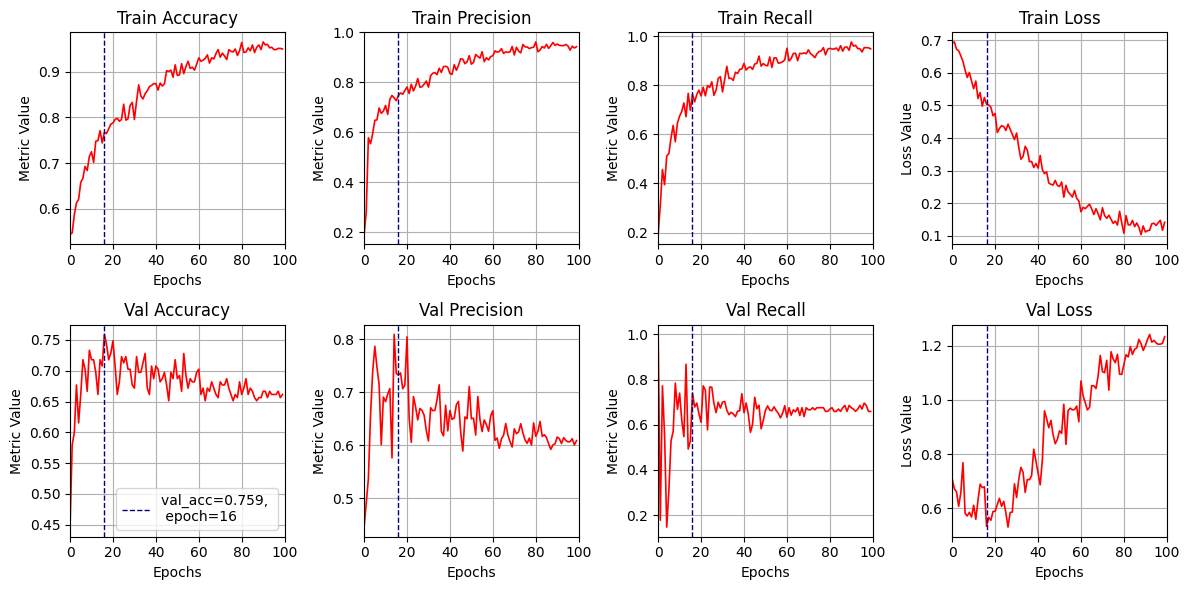

In [23]:
visualize_results(
    model_type="CustomCNN",
    version=0
)

Обучим ResNet-50 из `torchvision` с нуля:

In [24]:
ResNet50FS_callbacks = [
    ModelCheckpoint(monitor="val_accuracy", mode="max", save_top_k=1,
                    filename="ResNet50FS_{epoch}_{val_accuracy}"),
    LearningRateMonitor(logging_interval="step"),
    RichProgressBar()
]

In [26]:
train_model(
    model=ResNet50FS(),
    logger_name="ResNet50FS_logs",
    epochs=100,
    callbacks=ResNet50FS_callbacks,
    datamodule=datamodule,
    deterministic_train=False
)

Epoch 99/99 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49/49 0:00:30 • 0:00:00 1.65it/s v_num: 1 train_accuracy_step: 0.800
                                                                                train_rocauc_step: 0.833           
                                                                                train_loss_step: 0.384             
                                                                                val_accuracy: 0.682 val_rocauc:    
                                                                                0.690 val_loss: 0.775              
                                                                                train_accuracy_epoch: 0.951        
                                                                                train_rocauc_epoch: 0.960          
                                                                                train_loss_epoch: 0.133            

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [27]:
print("Лучший чекпоинт:", ResNet50FS_callbacks[0].best_model_path)

Лучший чекпоинт: ./drive/MyDrive/logs/ResNet50FS_logs/version_0/checkpoints/ResNet50FS_epoch=49_val_accuracy=0.8102564215660095.ckpt


Аналогично построим графики процесса обучения:

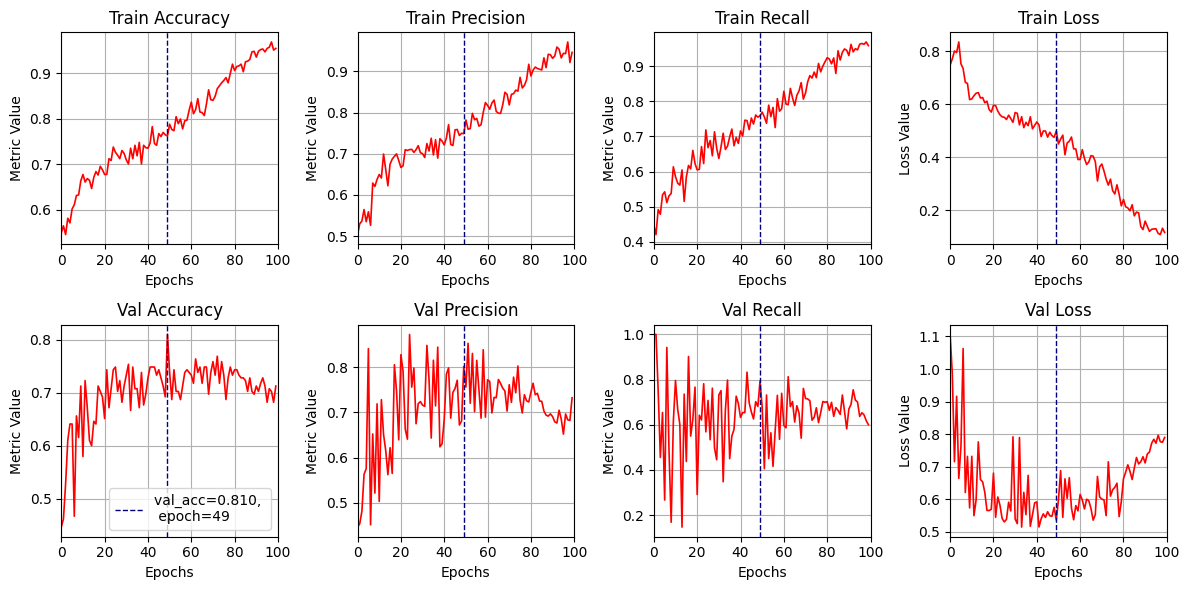

In [28]:
visualize_results(
    model_type="ResNet50FS",
    version=0
)

Обучим ResNet-50 с применением **transfer learning**:

In [32]:
ResNet50TL_callbacks = [
    ModelCheckpoint(monitor="val_accuracy", mode="max", save_top_k=1,
                    filename="ResNet50TL_{epoch}_{val_accuracy}"),
    LearningRateMonitor(logging_interval="step"),
    RichProgressBar()
]

In [33]:
train_model(
    model=ResNet50TL(),
    logger_name="ResNet50TL_logs",
    epochs=100,
    callbacks=ResNet50TL_callbacks,
    datamodule=datamodule,
    deterministic_train=False
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model │ ResNet │ 23.5 M │ train │
└───┴───────┴────────┴────────┴───────┘

Trainable params: 4.1 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 151                                                                                         
Modules in eval mode: 0

Output()

Metrics moved to cuda:0


INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [34]:
print("Лучший чекпоинт:", ResNet50TL_callbacks[0].best_model_path)

Лучший чекпоинт: ./drive/MyDrive/logs/ResNet50TL_logs/version_0/checkpoints/ResNet50TL_epoch=70_val_accuracy=0.8666666746139526.ckpt


Визуализируем метрики:

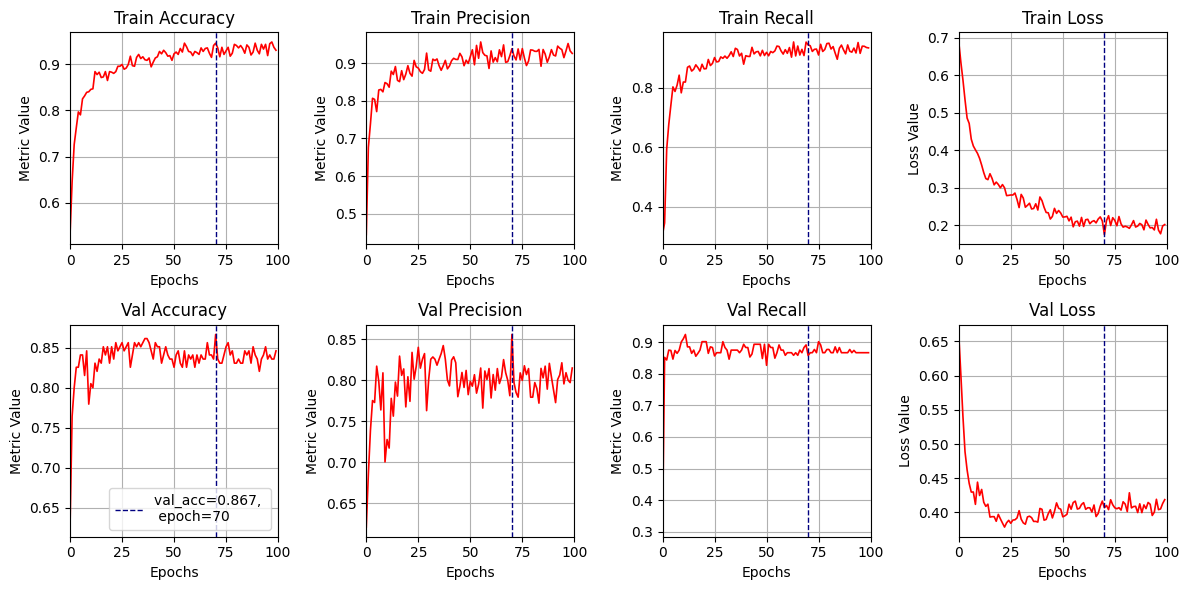

In [35]:
visualize_results(
    model_type="ResNet50TL",
    version=0
)

## Предсказание на других картинках

Зададим функцию для инференса модели на одной картинки, чтобы ради этого не инициализировать Dataset и Dataloader:

In [64]:
def inference_image(
    model,
    img_path: str,
    class_names: list[str, str] = classes,
    device: str = "cuda"
):
    device = torch.device(device)
    model.eval()
    model = model.to(device)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()
    ])

    img = transform(image=img)["image"].unsqueeze(0)  # add batch dim
    img = img.to(device)

    with torch.no_grad():
        logits = model(img)
        probs = torch.softmax(logits, dim=1)
        pred_class = logits.argmax(dim=1).item()
        conf = probs[0, pred_class].item()

    pred_label = class_names[pred_class]

    print(f"Предикт: {pred_label}")
    print(f"Confidence: {conf:.3f} \n")

    return pred_class, conf, probs

In [43]:
ckpt_path = "./drive/MyDrive/logs/ResNet50TL_logs/version_0/checkpoints/ResNet50TL_epoch=70_val_accuracy=0.8666666746139526.ckpt"
inference_model = ResNet50TL.load_from_checkpoint(checkpoint_path=ckpt_path)

In [56]:
test_ds_path = "./drive/MyDrive/test_dataset/"
test_gen_imgs, test_real_imgs = os.path.join(test_ds_path, "generated"), os.path.join(test_ds_path, "real")

In [70]:
gt = [0] * 8 + [1] * 8
preds = []

for idx, img_name in enumerate(os.listdir(test_gen_imgs) + os.listdir(test_real_imgs)):
    print(f"Название: {img_name}")
    print(f"Ground Truth: {classes[gt[idx]]}")
    predict, confidence, predict_probs = inference_image(
        model=inference_model,
        img_path=os.path.join(test_gen_imgs, img_name) if img_name.startswith("generated") else os.path.join(test_real_imgs, img_name)
    )
    preds.append(predict)

Название: generated_7.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.966 

Название: generated_8.jpg
Ground Truth: generated
Предикт: generated
Confidence: 0.591 

Название: generated_4.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.816 

Название: generated_5.jpg
Ground Truth: generated
Предикт: generated
Confidence: 0.995 

Название: generated_2.jpg
Ground Truth: generated
Предикт: generated
Confidence: 0.597 

Название: generated_6.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.992 

Название: generated_1.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.989 

Название: generated_3.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.961 

Название: real_4.jpg
Ground Truth: real
Предикт: real
Confidence: 0.805 

Название: real_5.JPG
Ground Truth: real
Предикт: real
Confidence: 0.970 

Название: real_3.jpg
Ground Truth: real
Предикт: real
Confidence: 0.829 

Название: real_8.jpg
Ground Truth: real
Предикт: real
Confidence: 0.560 

Название: real_1.

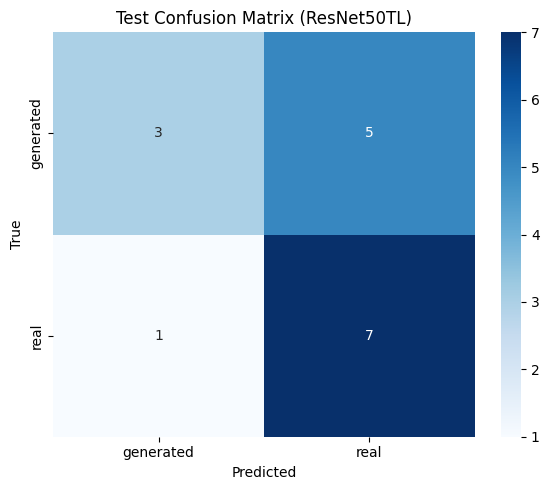


 Accuracy: 0.625


In [77]:
cm = sl.metrics.confusion_matrix(gt, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)

plt.title("Test Confusion Matrix (ResNet50TL)")
plt.ylabel("True")
plt.xlabel("Predicted")

plt.tight_layout()
plt.show()

print(f"\n Accuracy: {(cm[0, 0] + cm[1, 1]) / 16}")

Для сравнения посмотрим на результат других моделей:

In [82]:
inference_model_2 = ResNet50FS.load_from_checkpoint(
    "./drive/MyDrive/logs/ResNet50FS_logs/version_0/checkpoints/ResNet50FS_epoch=49_val_accuracy=0.8102564215660095.ckpt"
)
preds_2 = []
for idx, img_name in enumerate(os.listdir(test_gen_imgs) + os.listdir(test_real_imgs)):
    print(f"Название: {img_name}")
    print(f"Ground Truth: {classes[gt[idx]]}")
    predict, confidence, predict_probs = inference_image(
        model=inference_model_2,
        img_path=os.path.join(test_gen_imgs, img_name) if img_name.startswith("generated") else os.path.join(test_real_imgs, img_name)
    )
    preds_2.append(predict)

Название: generated_7.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.920 

Название: generated_8.jpg
Ground Truth: generated
Предикт: generated
Confidence: 0.658 

Название: generated_4.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.768 

Название: generated_5.jpg
Ground Truth: generated
Предикт: generated
Confidence: 0.914 

Название: generated_2.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.711 

Название: generated_6.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.986 

Название: generated_1.jpg
Ground Truth: generated
Предикт: generated
Confidence: 0.544 

Название: generated_3.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.760 

Название: real_4.jpg
Ground Truth: real
Предикт: real
Confidence: 0.730 

Название: real_5.JPG
Ground Truth: real
Предикт: real
Confidence: 0.743 

Название: real_3.jpg
Ground Truth: real
Предикт: generated
Confidence: 0.894 

Название: real_8.jpg
Ground Truth: real
Предикт: real
Confidence: 0.849 

Название: re

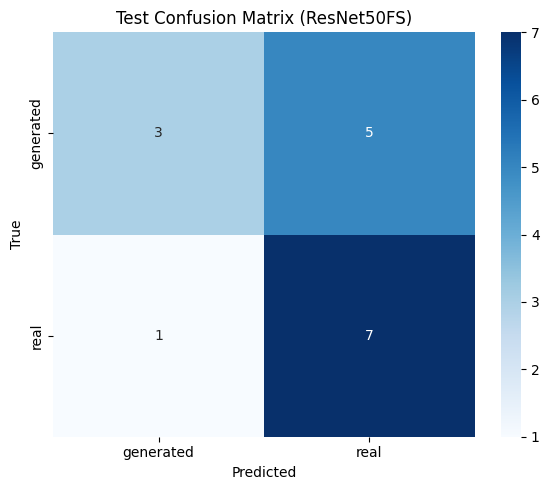


 Accuracy: 0.625


In [86]:
cm_2 = sl.metrics.confusion_matrix(gt, preds_2)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)

plt.title("Test Confusion Matrix (ResNet50FS)")
plt.ylabel("True")
plt.xlabel("Predicted")

plt.tight_layout()
plt.show()

print(f"\n Accuracy: {(cm_2[0, 0] + cm_2[1, 1]) / 16}")

In [84]:
inference_model_3 = CustomCNN.load_from_checkpoint(
    "./drive/MyDrive/logs/CustomCNN_logs/version_0/checkpoints/CustomCNN_epoch=16_val_accuracy=0.7589743733406067.ckpt"
)
preds_3 = []
for idx, img_name in enumerate(os.listdir(test_gen_imgs) + os.listdir(test_real_imgs)):
    print(f"Название: {img_name}")
    print(f"Ground Truth: {classes[gt[idx]]}")
    predict, confidence, predict_probs = inference_image(
        model=inference_model_3,
        img_path=os.path.join(test_gen_imgs, img_name) if img_name.startswith("generated") else os.path.join(test_real_imgs, img_name)
    )
    preds_3.append(predict)

Название: generated_7.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.824 

Название: generated_8.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.702 

Название: generated_4.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.700 

Название: generated_5.jpg
Ground Truth: generated
Предикт: generated
Confidence: 0.892 

Название: generated_2.jpg
Ground Truth: generated
Предикт: generated
Confidence: 0.568 

Название: generated_6.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.959 

Название: generated_1.jpg
Ground Truth: generated
Предикт: generated
Confidence: 0.502 

Название: generated_3.jpg
Ground Truth: generated
Предикт: real
Confidence: 0.841 

Название: real_4.jpg
Ground Truth: real
Предикт: real
Confidence: 0.775 

Название: real_5.JPG
Ground Truth: real
Предикт: real
Confidence: 0.588 

Название: real_3.jpg
Ground Truth: real
Предикт: generated
Confidence: 0.868 

Название: real_8.jpg
Ground Truth: real
Предикт: real
Confidence: 0.672 

Название: re

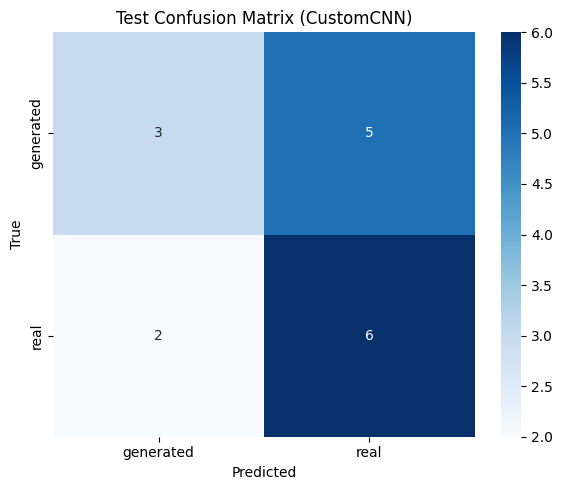


 Accuracy: 0.5625


In [87]:
cm_3 = sl.metrics.confusion_matrix(gt, preds_3)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)

plt.title("Test Confusion Matrix (CustomCNN)")
plt.ylabel("True")
plt.xlabel("Predicted")

plt.tight_layout()
plt.show()

print(f"\n Accuracy: {(cm_3[0, 0] + cm_3[1, 1]) / 16}")

## **Выводы**

Результаты получились следующие:


*   **CustomCNN**: val_accuracy = 0.759, test_accuracy = 0.563
*   **ResNet50FS**: val_accuracy = 0.810, test_accuracy = 0.625
*   **ResNet50TL**: val_accuracy = 0.867, test_accuracy = 0.625

Таким образом, лучшей по результатам валидации стала модель ResNet50, обученная с использованием transfer learning (обучалась только голова, бэкбон заморожен). Но по результатам теста предсказания далеко не идеальные.

